In [1]:
#Setting up dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, cv2, shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
DATASET_PATH = '/content/drive/MyDrive/realwaste/RealWaste'  # Adjust this path
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
EPOCHS = 20
SEED = 42


In [6]:
def load_dataset(dataset_path, img_height=128, img_width=128):
    """
    Load images from the RealWaste dataset structure
    Assumes structure: dataset_path/class_name/images
    """
    images = []
    labels = []
    class_names = []

    # Get all class folders
    class_folders = [f for f in os.listdir(dataset_path)
                     if os.path.isdir(os.path.join(dataset_path, f))]
    class_folders.sort()
    class_names = class_folders

    print(f"Found {len(class_names)} classes: {class_names}")

    # Load images from each class
    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name)
        image_files = [f for f in os.listdir(class_path)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        print(f"Loading {len(image_files)} images from class '{class_name}'...")

        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            try:
                # Read and resize image
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (img_width, img_height))
                images.append(img)
                labels.append(class_idx)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    # Convert to numpy arrays
    images = np.array(images, dtype='float32') / 255.0  # Normalize to [0,1]
    labels = np.array(labels)

    print(f"\nTotal images loaded: {len(images)}")
    print(f"Image shape: {images[0].shape}")
    print(f"Number of classes: {len(class_names)}")

    return images, labels, class_names


In [7]:


# Load data
X, y, class_names = load_dataset(DATASET_PATH, IMG_HEIGHT, IMG_WIDTH)
num_classes = len(class_names)

# ================================
# 4. TRAIN-VAL-TEST SPLIT (70-15-15)
# ================================
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp)

print(f"\nSplit: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")

Found 9 classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Loading 469 images from class 'Cardboard'...
Loading 411 images from class 'Food Organics'...
Loading 420 images from class 'Glass'...
Loading 790 images from class 'Metal'...
Loading 495 images from class 'Miscellaneous Trash'...
Loading 500 images from class 'Paper'...
Loading 921 images from class 'Plastic'...
Loading 318 images from class 'Textile Trash'...
Loading 436 images from class 'Vegetation'...

Total images loaded: 4760
Image shape: (128, 128, 3)
Number of classes: 9

Split: Train=3332, Val=714, Test=714


In [8]:
# Convert to categorical
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_val_cat   = keras.utils.to_categorical(y_val,   num_classes)
y_test_cat  = keras.utils.to_categorical(y_test,  num_classes)

In [9]:
#================================
# 5. DATA AUGMENTATION
# ================================
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(
    X_train, y_train_cat,
    batch_size=BATCH_SIZE,
    seed=SEED
)

In [10]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict)

Class weights: {0: np.float64(1.1287262872628727), 1: np.float64(1.2854938271604939), 2: np.float64(1.2592592592592593), 3: np.float64(0.6694796061884669), 4: np.float64(1.0700064226075787), 5: np.float64(1.0577777777777777), 6: np.float64(0.5739879414298019), 7: np.float64(1.6601893373193821), 8: np.float64(1.2138433515482696)}


In [11]:
def build_custom_cnn(input_shape, num_classes):
    model = models.Sequential([
        # Block 1
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.3),

        # Block 3
        layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.4),

        # Flatten + Fully Connected
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model



In [12]:
# Build model
model = build_custom_cnn((IMG_HEIGHT, IMG_WIDTH, 3), num_classes)
model.compile(
    optimizer=optimizers.SGD(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n" + "="*60)
print("IMPROVED CNN MODEL SUMMARY")
print("="*60)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



IMPROVED CNN MODEL SUMMARY


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,681,001 (33.12 MB)

 Trainable params: 8,679,593 (33.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [13]:
lr_reducer = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)
#================================
# 8. TRAIN MODEL
# ================================
print("\n" + "="*60)
print("STARTING TRAINING...")
print("="*60)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=(X_val, y_val_cat),
    callbacks=[lr_reducer],
    class_weight=class_weights_dict,
    verbose=1
)


STARTING TRAINING...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 48s 312ms/step - accuracy: 0.1841 - loss: 2.9541 - val_accuracy: 0.0882 - val_loss: 3.6264 - learning_rate: 0.0010
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 0.3166 - loss: 2.3290 - val_accuracy: 0.0882 - val_loss: 4.7080 - learning_rate: 0.0010
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 0.3817 - loss: 1.9609 - val_accuracy: 0.0882 - val_loss: 5.5446 - learning_rate: 0.0010
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.3807 - loss: 1.9709
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - accuracy: 0.3809 - loss: 1.9704 - val_accuracy: 0.0994 - val_loss: 4.4389 - learning_rate: 0.0010
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - accuracy: 0.4237 - loss: 1.8505 - val_accuracy: 0.2157 - val_loss: 3.2161 - learning_rate: 5.0000e-04
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 0


PLOTTING TRAINING RESULTS


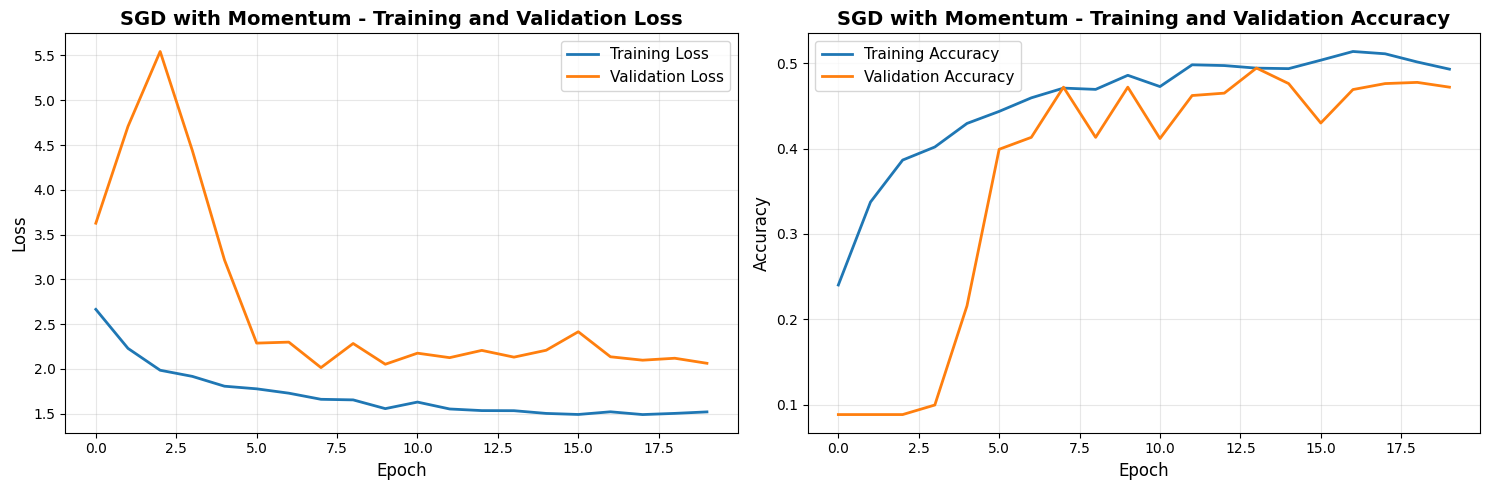

✓ Training plots saved


In [14]:

# ============================================================================
# PLOTTING TRAINING RESULTS
# ============================================================================

print("\n" + "="*70)
print("PLOTTING TRAINING RESULTS")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('SGD with Momentum - Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot Accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_title('SGD with Momentum - Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_SGD_MOM.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Training plots saved")


MODEL EVALUATION

Train Accuracy: 0.4874
Test Accuracy: 0.4818
Train Loss: 1.9691
Test Loss: 1.9409

Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.79      0.21      0.34        70
      Food Organics       0.42      0.77      0.54        61
              Glass       0.61      0.68      0.65        63
              Metal       0.37      0.78      0.50       119
Miscellaneous Trash       0.31      0.27      0.29        75
              Paper       0.74      0.23      0.35        75
            Plastic       0.70      0.27      0.39       138
      Textile Trash       0.47      0.17      0.25        48
         Vegetation       0.62      0.98      0.76        65

           accuracy                           0.48       714
          macro avg       0.56      0.48      0.45       714
       weighted avg       0.56      0.48      0.45       714



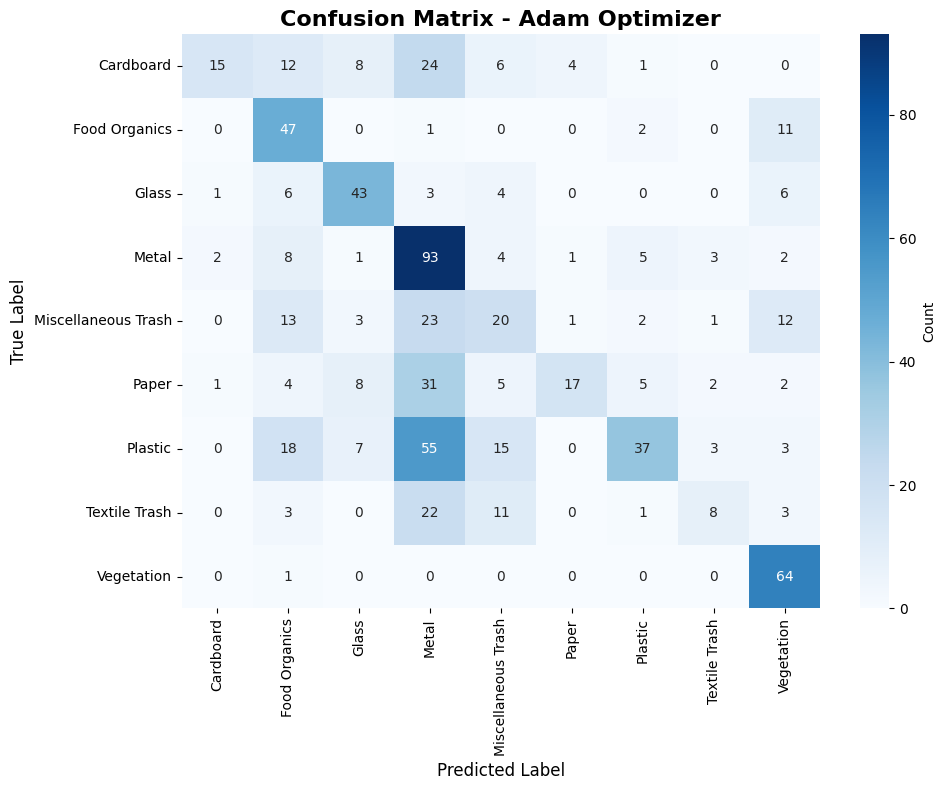

✓ Confusion matrix saved

PERFORMANCE SUMMARY
Optimizer  Train Accuracy  Train Loss  Test Accuracy  Test Loss  Precision   Recall  F1-Score
     Adam        0.487395    1.969061       0.481793   1.940911   0.558815 0.484618  0.450727

✓ Results saved to 'model_results.csv'


In [15]:

# ============================================================================
# EVALUATE MODEL
# ============================================================================

print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70)

# Get predictions
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# Calculate metrics
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
train_loss, train_acc = model.evaluate(X_train, y_train_cat, verbose=0)

# Print results
print(f"\nTrain Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Train Loss: {train_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

report = classification_report(y_test, y_pred,
                               target_names=class_names,
                               output_dict=True)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Adam Optimizer', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_adam.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Confusion matrix saved")

# Create results summary
results_data = {
    'Optimizer': 'Adam',
    'Train Accuracy': train_acc,
    'Train Loss': train_loss,
    'Test Accuracy': test_acc,
    'Test Loss': test_loss,
    'Precision': report['macro avg']['precision'],
    'Recall': report['macro avg']['recall'],
    'F1-Score': report['macro avg']['f1-score']
}

# Create DataFrame
results_df = pd.DataFrame([results_data])

print("\n" + "="*70)
print("PERFORMANCE SUMMARY")
print("="*70)
print(results_df.to_string(index=False))

# Save results to CSV
results_df.to_csv('model_results.csv', index=False)
print("\n✓ Results saved to 'model_results.csv'")

In [16]:



# ============================================================================
# SAVE MODEL
# ============================================================================

print("\n" + "="*70)
print("SAVING MODEL")
print("\n" + "="*70)

# Save model
model.save('/content/drive/MyDrive/realwaste2/model_tune.h5')
print(f"✓ Adam model saved")

print("\n" + "="*70)
print("TRAINING AND EVALUATION COMPLETE!")
print("\n" + "="*70)
print("\nGenerated Files:")
print("  - training_adam.png (Loss and Accuracy plots)")
print("  - confusion_matrix_adam.png")
print("  - model_results.csv")
print("  - model_adam.h5 (Saved model)")



SAVING MODEL

✓ Adam model saved

TRAINING AND EVALUATION COMPLETE!


Generated Files:
  - training_adam.png (Loss and Accuracy plots)
  - confusion_matrix_adam.png
  - model_results.csv
  - model_adam.h5 (Saved model)


In [ ]:
import shutil
from google.colab import files

# Save model
model.save('model_adam.h5')

# Compress it
shutil.make_archive('model_adam', 'zip', '.', 'model_adam.h5')

# Download the zip file
files.download('model_adam.zip')